Auto Encoder


*   Sigmoid
*   24 --> 10 --> 8 --> |5| --> 8 -->10 --> 24
*   Raw Score: 43.318518518518516
*   Grade: Moderate
*   Score: 43
*   Patient ID: SB-001
*   Batch Norm: No



In [2]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# Load Data
df_am = pd.read_csv('SB-001_normalized_AM.csv')
df_pm = pd.read_csv('SB-001_normalized_PM.csv')
FILE_NAME  = "Auto Encoder-L24_10_08_05_08-S43-ALSigmoid-E200-Psb001-BNn"
PATIENT_ID = "SB-001"
combined_df = pd.concat([df_am, df_pm])

columns_needed = ['y_am_pef', 'tempin', 'humidin', 'pm25in', 'co2in', 'tempdiffin', 'humidiffin', 'pm25diffin', 'pm10', 'pm25', 'o3', 'no2', 'co', 'so2', 'temp', 'windsd', 'humid', 'varp', 'dewpt', 'airp', 'seap', 'solrhr', 'solramnt', 'grdt', 'class']
combined_df = combined_df.filter(columns_needed)
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,pm25diffin,pm10,pm25,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,NaN,0.247,0.170,0.324,0.158,0.749,0.410,0.595,0.365,0.070,...,0.384,0.280,0.061,0.231,0.602,0.611,0.781,0.299,0.194,1.0
1,NaN,0.577,0.630,0.318,0.512,0.103,0.627,0.246,0.565,0.455,...,0.038,0.442,0.497,0.760,0.528,0.517,0.898,0.844,0.844,1.0
2,NaN,0.282,0.314,0.389,0.419,0.555,0.105,0.215,0.557,0.543,...,0.275,0.687,0.209,0.505,0.902,0.895,0.448,0.132,0.240,1.0
3,0.421,0.431,0.283,0.231,0.083,0.421,0.588,0.557,0.241,0.080,...,0.799,0.197,0.181,0.461,0.372,0.373,0.927,0.807,0.452,1.0
4,0.350,0.597,0.647,0.599,0.439,0.338,0.276,0.319,0.666,0.653,...,0.034,0.798,0.479,0.746,0.564,0.557,0.614,0.648,0.645,1.0


In [4]:
# Drop NaN
df = df.dropna()
print(len(df))

# Minotity Split
class_counts = df['class'].value_counts()
minority_class = df[df['class'] == 0]
majority_class = df[df['class'] == 1]

188


In [5]:
# Removing class column from minority before augmentation
X = minority_class.drop('class', axis=1)
y = minority_class['class']

# Saving minority as X_train
X_train = X
print(X_train.shape)

(57, 24)


In [6]:
X_train.head()

,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,pm25diffin,pm10,pm25,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
6,0.268,0.851,0.660,0.154,0.628,0.247,0.455,0.492,0.249,0.088,...,0.822,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694
7,0.415,0.425,0.253,0.342,0.344,0.585,0.346,0.348,0.616,0.405,...,0.430,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272
17,0.310,0.556,0.429,0.796,0.357,0.576,0.310,0.623,0.599,0.477,...,0.466,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291
23,0.284,0.813,0.749,0.291,0.384,0.154,0.396,0.518,0.404,0.173,...,0.898,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836
25,0.228,0.143,0.000,0.108,0.146,0.992,0.445,0.508,0.259,0.031,...,0.007,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021


In [7]:
# Check no NaN exists
nan_count = X_train.isna().sum()
columns_with_nan = nan_count[nan_count > 0]

print("Columns with NaN values:")
print(columns_with_nan)

Columns with NaN values:
Series([], dtype: int64)


In [8]:
# Define the Input shape
INPUT_SHAPE = X_train.shape[1]
INPUT_SHAPE

24

In [9]:
def build_autoencoder(input_shape, **kwargs):
    """
    Build an autoencoder model with the given configuration.

    Args:
        input_shape (int): The shape of the input data.
        **kwargs: Additional keyword arguments for configuring the autoencoder.

    Keyword Args:
        encoder_dense_layers (list): List of integers specifying the number of units for each dense layer in the encoder.
                                    Default: []
        bottle_neck (int): The number of units in the bottleneck layer. Default: input_shape // 2
        decoder_dense_layers (list): List of integers specifying the number of units for each dense layer in the decoder.
                                    Default: []
        decoder_activation (str): The activation function for the decoder output layer. Default: 'sigmoid'

    Returns:
        tuple: A tuple containing the autoencoder, encoder, and decoder models.

    Example:
        INPUT_SHAPE = 27
        encoder_dense_layers = [20, 18]  # Specify the number of units for each dense layer in the encoder
        bottle_neck = 16
        decoder_dense_layers = [18, 20]  # Specify the number of units for each dense layer in the decoder

        autoencoder, encoder, decoder = build_autoencoder(INPUT_SHAPE, encoder_dense_layers=encoder_dense_layers,
                                                          bottle_neck=bottle_neck, decoder_dense_layers=decoder_dense_layers)
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
    """

    # Default parameter values
    encoder_dense_layers = kwargs.get('encoder_dense_layers', [])
    bottle_neck = kwargs.get('bottle_neck', input_shape // 2)
    decoder_dense_layers = kwargs.get('decoder_dense_layers', [])
    decoder_activation = kwargs.get('decoder_activation', 'sigmoid')

    # Autoencoder Model
    encoder_input = keras.Input(shape=(input_shape,), name="encoder")
    x = keras.layers.Flatten()(encoder_input)

    # Encoder Dense Layers
    for units in encoder_dense_layers:
        x = keras.layers.Dense(units, activation="relu")(x)

    encoder_output = keras.layers.Dense(bottle_neck, activation="relu")(x)
    encoder = keras.Model(encoder_input, encoder_output, name="encoder")

    # Decoder Model
    decoder_input = keras.Input(shape=(bottle_neck,), name="decoder")
    x = decoder_input

    # Decoder Dense Layers
    for units in decoder_dense_layers:
        x = keras.layers.Dense(units, activation="relu")(x)

    decoder_output = keras.layers.Dense(input_shape, activation=decoder_activation)(x)
    decoder = keras.Model(decoder_input, decoder_output, name="decoder")

    # Autoencoder Model
    autoencoder_input = keras.Input(shape=(input_shape,), name="input")
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = keras.Model(autoencoder_input, decoded, name="autoencoder")

    return autoencoder, encoder, decoder

In [10]:
# Example usage:
encoder_dense_layers = [10, 8]  # Specify the number of units for each dense layer in the encoder
bottle_neck = 5
decoder_dense_layers = [8, 10]  # Specify the number of units for each dense layer in the decoder

autoencoder, encoder, decoder = build_autoencoder(INPUT_SHAPE, encoder_dense_layers=encoder_dense_layers,
                                                  bottle_neck=bottle_neck, decoder_dense_layers=decoder_dense_layers)
#autoencoder.summary()
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 24)]              0         
                                                                 
 encoder (Functional)        (None, 5)                 383       
                                                                 
 decoder (Functional)        (None, 24)                402       
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Network Shape
print(INPUT_SHAPE, encoder_dense_layers , bottle_neck, decoder_dense_layers, INPUT_SHAPE)

24 [10, 8] 5 [8, 10] 24


In [12]:
#print(help(build_autoencoder))

In [ ]:
!pip install tf2onnx

In [14]:
# import tf2onnx

# onnx_model_path = "autoencoder.onnx"
# onnx_model, _ = tf2onnx.convert.from_keras(autoencoder)
# with open(onnx_model_path, "wb") as f:
#     f.write(onnx_model.SerializeToString())

# print("Model saved as ONNX.")

## TO visualize .onnx model
# netron.start(onnx_model_path)

In [15]:
opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(opt, loss = "mse")

In [16]:
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size = 16, validation_split = 0.25)

Epoch 1/200
3/3 [==============================] - 2s 149ms/step - loss: 0.0617 - val_loss: 0.0670
Epoch 2/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0611 - val_loss: 0.0666
Epoch 3/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0605 - val_loss: 0.0663
Epoch 4/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0601 - val_loss: 0.0660
Epoch 5/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0597 - val_loss: 0.0658
Epoch 6/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0594 - val_loss: 0.0655
Epoch 7/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0591 - val_loss: 0.0653
Epoch 8/200
3/3 [==============================] - 0s 21ms/step - loss: 0.0588 - val_loss: 0.0650
Epoch 9/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0585 - val_loss: 0.0647
Epoch 10/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0582 - val_loss: 0.0643
Epoch 11/200
3/3 [

In [17]:
#Saving history
import pickle

with open( FILE_NAME + '_history' + '.pickle', 'wb') as file:
    pickle.dump(history.history, file)

# with open('history_Auto Encoder_Leaky RELU-40.pickle', 'rb') as file:
#     history = pickle.load(file)

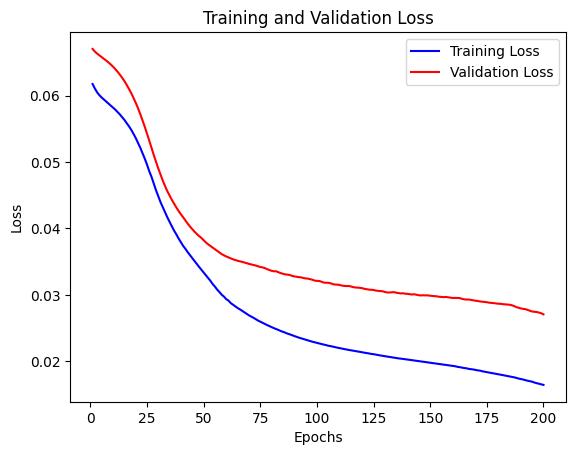

In [18]:
# Visualize losses *(MSE)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Difference in majority and minority class:
# We balance the dataset by generating no(synthetic data), in a way such that, after augmentation
# len(majority_class) would = len (minority_class)
difference = len(majority_class) - len(minority_class)
print(difference)

74


In [20]:
# Generating synthetic data as much as training data
# keeing data points same for report generation later
num_samples = len(X_train)
input_data = np.random.normal(size=(num_samples, INPUT_SHAPE)) # <-------

generated_data = autoencoder.predict(input_data) # <-------
generated_data.shape

2/2 [==============================] - 0s 11ms/step


(57, 24)

In [21]:
# Re shape data
reshaped_data = generated_data.reshape(num_samples, -1)

# Convert it to a DataFrame
df_generated = pd.DataFrame(reshaped_data, columns=X_train.columns)

# Display the dataframe
df_generated.head(3)

,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,pm25diffin,pm10,pm25,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.325167,0.651531,0.593846,0.502163,0.368705,0.430856,0.344306,0.345374,0.666005,0.612149,...,0.554635,0.266518,0.712828,0.399989,0.603468,0.562102,0.534326,0.400435,0.286232,0.461414
1,0.220227,0.450823,0.243726,0.195005,0.197320,0.723413,0.358249,0.480904,0.400341,0.133701,...,0.250505,0.446568,0.310454,0.066245,0.244912,0.752438,0.765086,0.687715,0.174268,0.156891
2,0.230958,0.737626,0.646168,0.299865,0.595182,0.331645,0.499202,0.552315,0.437584,0.124627,...,0.857091,0.221341,0.484578,0.408346,0.718492,0.405046,0.451368,0.434216,0.468722,0.635256


In [22]:
print("Minority data shape:", X_train.shape)
print("Synthetic generated data shape:", df_generated.shape)

Minority data shape: (57, 24)
Synthetic generated data shape: (57, 24)


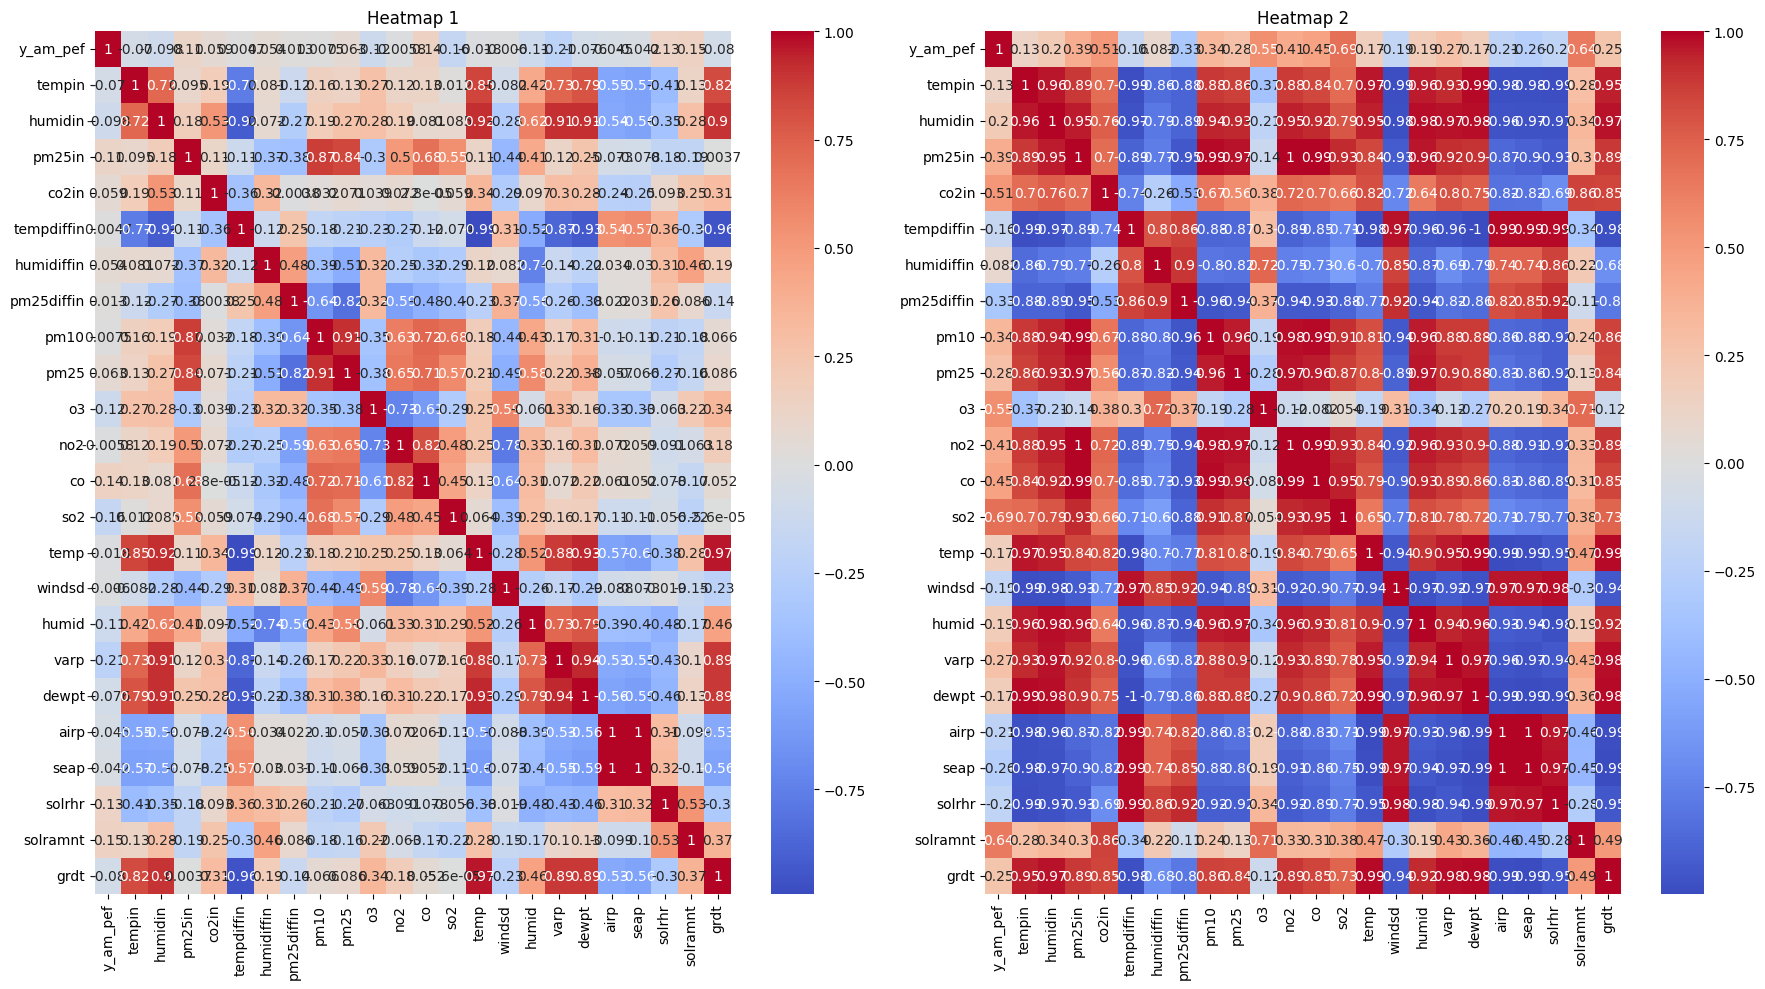

In [23]:
# Plot the Co-relation matrix
corr_matrix1 = X_train.corr()
corr_matrix2 = df_generated.corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Heatmap 1')

sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Heatmap 2')

plt.tight_layout()

plt.show()

In [24]:
 # Calculating mean and standard deviation of original and synthetic dataset
common_columns = set(X_train.columns) & set(df_generated.columns)
results = {}

for column in common_columns:

    mean_df1 = X_train[column].mean()
    std_df1 = X_train[column].std()
    mean_df2 = df_generated[column].mean()
    std_df2 = df_generated[column].std()


    results[column] = {'Mean_df1': mean_df1, 'Std_df1': std_df1,
                       'Mean_df2': mean_df2, 'Std_df2': std_df2}


comparison_df = pd.DataFrame(results)

# Display the comparison dataframe
print(comparison_df)

             co2in    windsd     dewpt  pm25diffin  solramnt    solrhr  \
Mean_df1  0.353421  0.364246  0.436825    0.451018  0.292614  0.547509   
Std_df1   0.161209  0.258312  0.216589    0.123570  0.168519  0.264203   
Mean_df2  0.285747  0.453674  0.346817    0.457559  0.252825  0.619951   
Std_df2   0.083941  0.168892  0.200064    0.084448  0.054770  0.165950   

          humidiffin      temp      pm25  tempdiffin  ...       so2      varp  \
Mean_df1    0.449263  0.458368  0.262298    0.575035  ...  0.266860  0.212842   
Std_df1     0.200516  0.219518  0.235978    0.204747  ...  0.142201  0.180177   
Mean_df2    0.417377  0.340670  0.267752    0.655458  ...  0.260124  0.173016   
Std_df2     0.082220  0.185300  0.209715    0.185064  ...  0.082126  0.136058   

              grdt   humidin    tempin    pm25in      seap     humid  \
Mean_df1  0.332772  0.356877  0.517070  0.308474  0.649105  0.388579   
Std_df1   0.205322  0.184544  0.212387  0.174530  0.177951  0.235243   
Mean_df

In [25]:
comparison_df.to_csv(FILE_NAME +'_mean&std.csv', index=True)

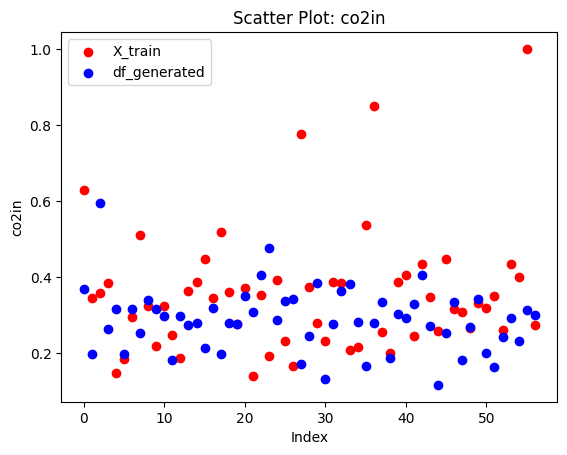

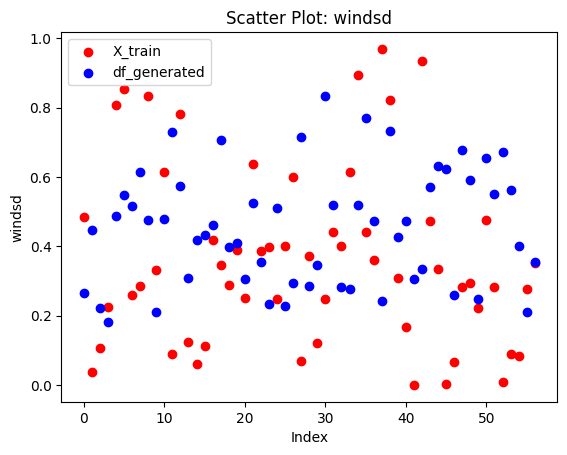

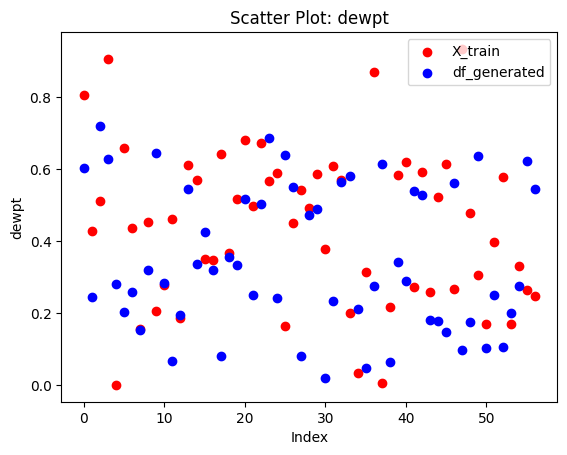

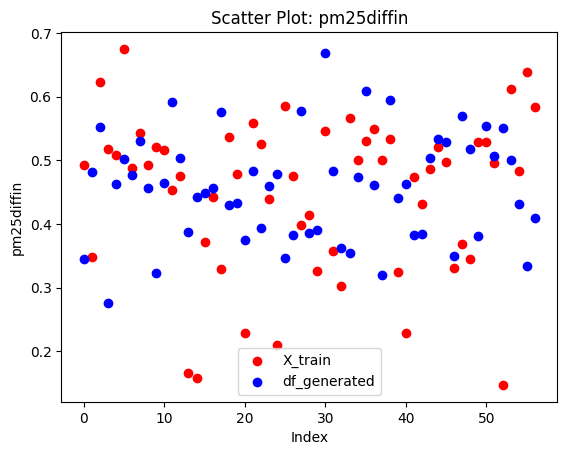

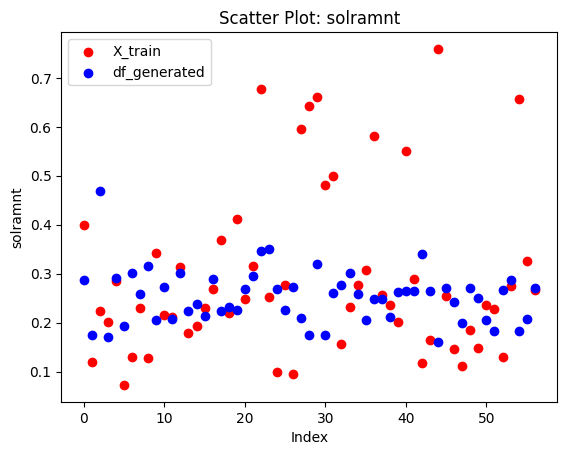

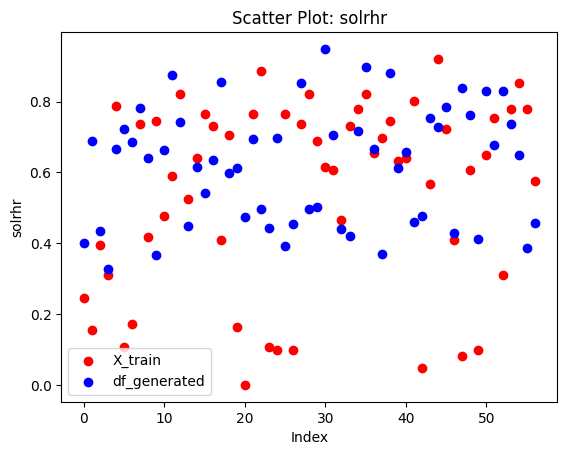

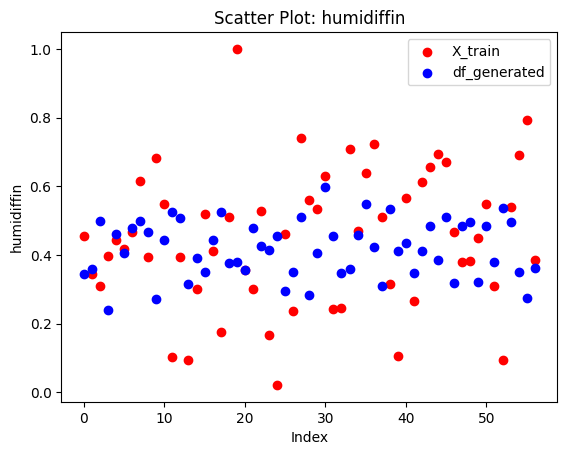

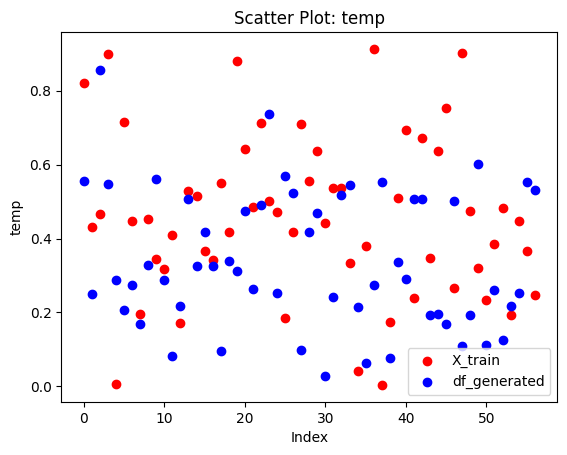

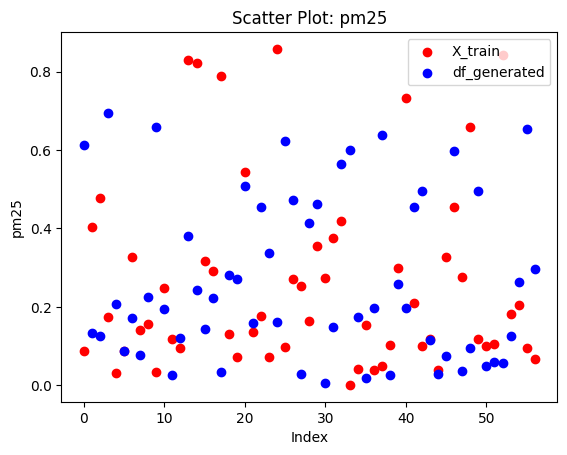

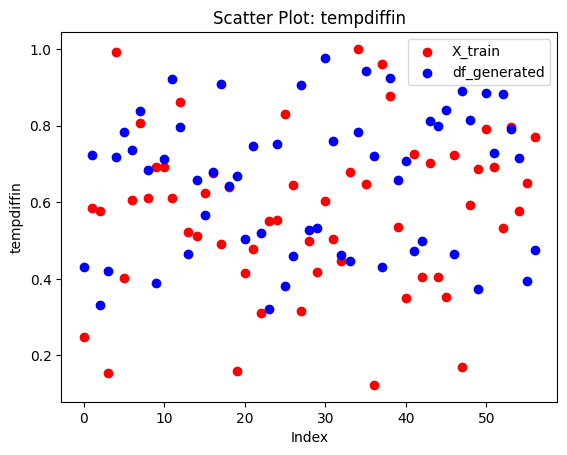

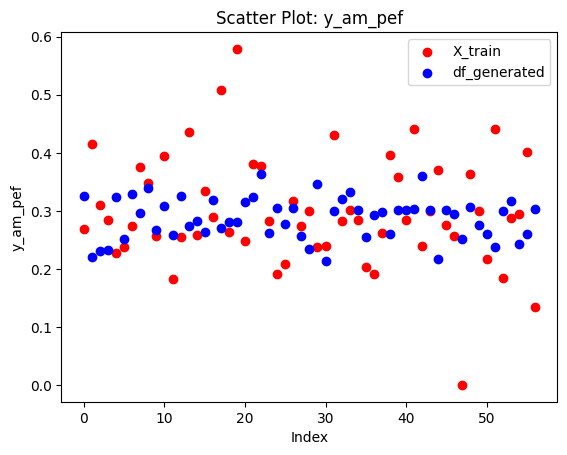

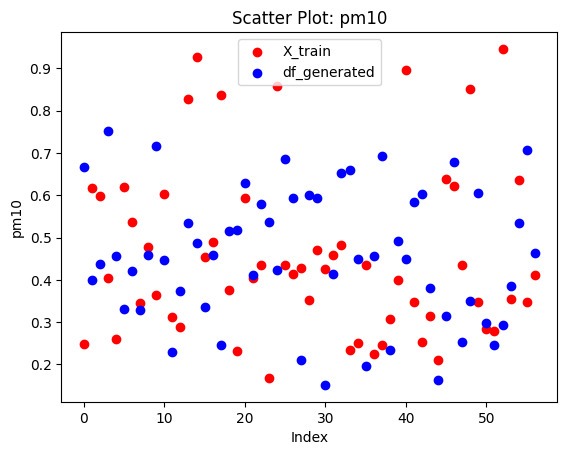

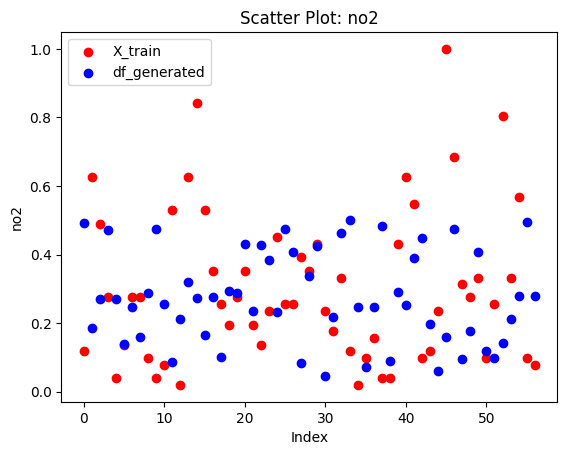

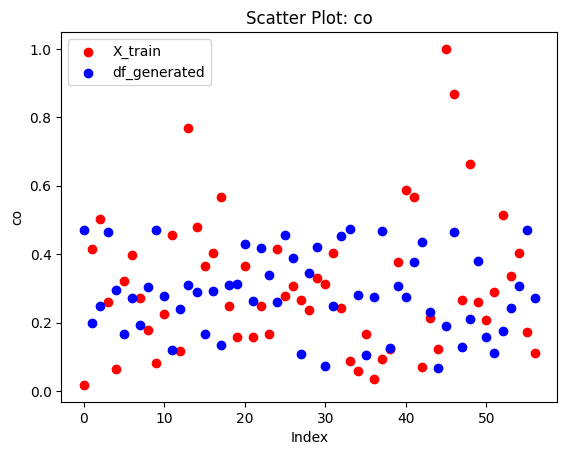

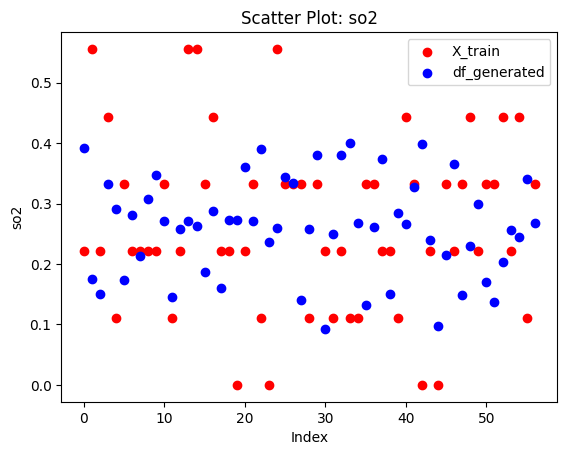

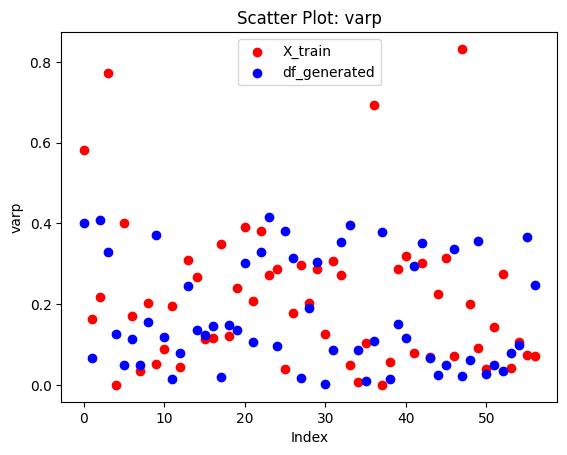

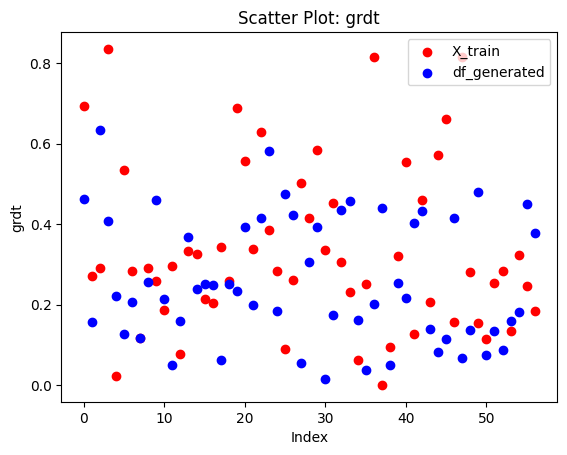

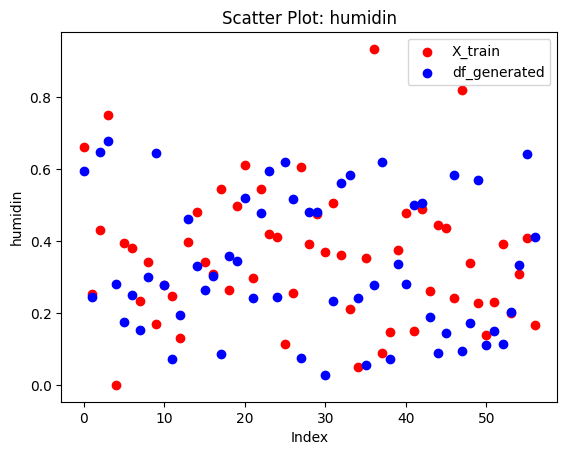

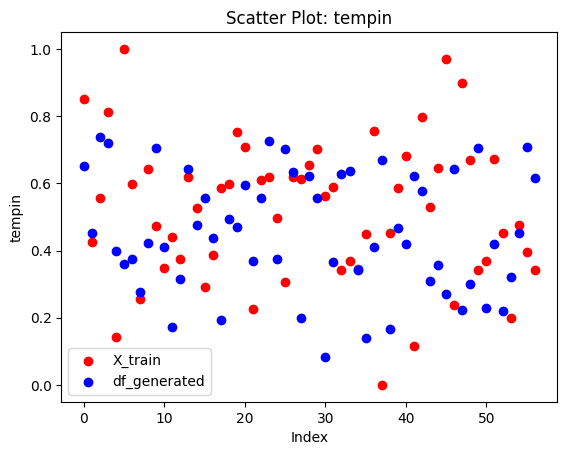

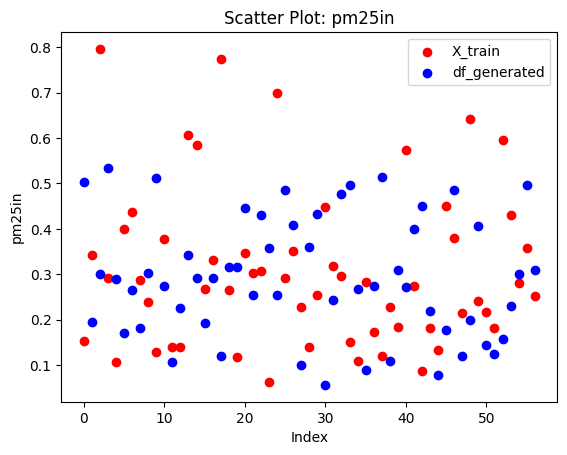

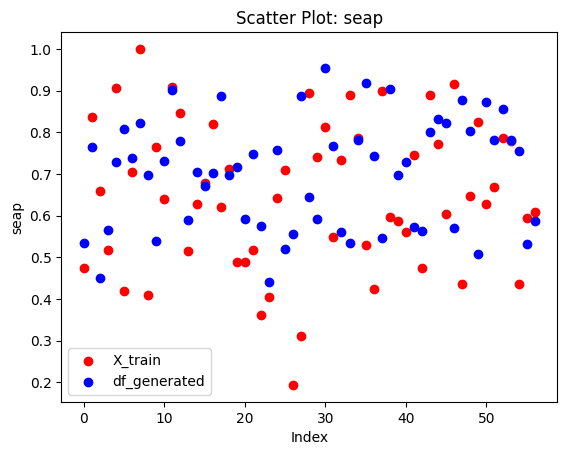

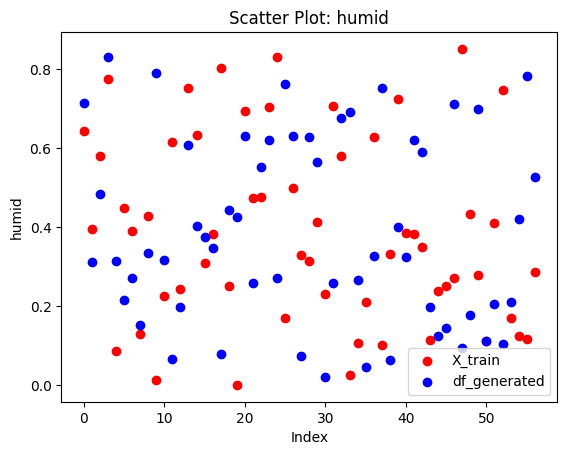

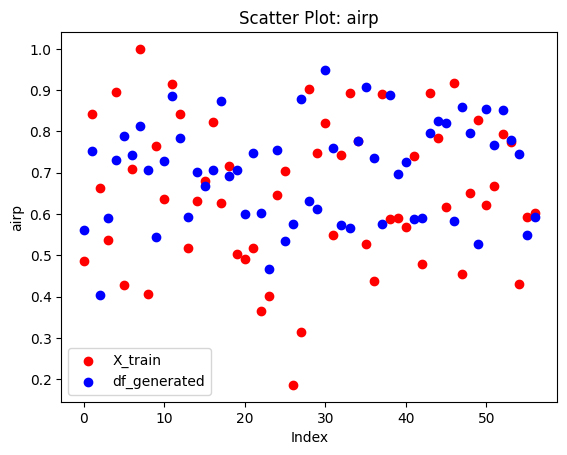

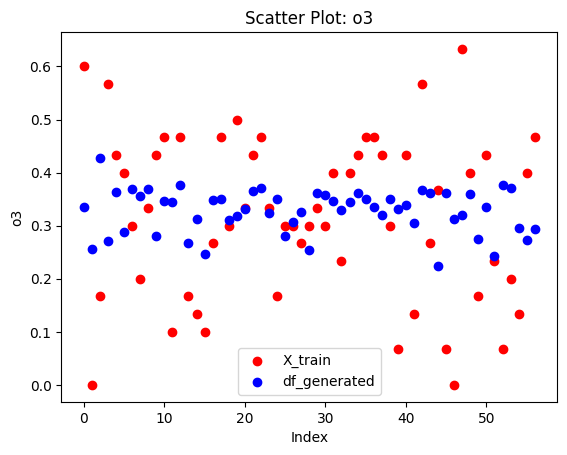

In [26]:
new_index = pd.RangeIndex(start=0, stop=57, step=1)
X_train = X_train.set_index(new_index)

import matplotlib.pyplot as plt

common_columns = set(X_train.columns) & set(df_generated.columns)
for column in common_columns:

    plt.scatter(X_train.index, X_train[column], color='red', label='X_train')
    plt.scatter(df_generated.index, df_generated[column], color='blue', label='df_generated')

    plt.title(f"Scatter Plot: {column}")
    plt.xlabel("Index")
    plt.ylabel(column)

    plt.legend()
    plt.show()

In [27]:
X_train.head()

,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,pm25diffin,pm10,pm25,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.268,0.851,0.660,0.154,0.628,0.247,0.455,0.492,0.249,0.088,...,0.822,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694
1,0.415,0.425,0.253,0.342,0.344,0.585,0.346,0.348,0.616,0.405,...,0.430,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272
2,0.310,0.556,0.429,0.796,0.357,0.576,0.310,0.623,0.599,0.477,...,0.466,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291
3,0.284,0.813,0.749,0.291,0.384,0.154,0.396,0.518,0.404,0.173,...,0.898,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836
4,0.228,0.143,0.000,0.108,0.146,0.992,0.445,0.508,0.259,0.031,...,0.007,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021


In [28]:
df_generated.head()

,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,pm25diffin,pm10,pm25,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.325167,0.651531,0.593846,0.502163,0.368705,0.430856,0.344306,0.345374,0.666005,0.612149,...,0.554635,0.266518,0.712828,0.399989,0.603468,0.562102,0.534326,0.400435,0.286232,0.461414
1,0.220227,0.450823,0.243726,0.195005,0.197320,0.723413,0.358249,0.480904,0.400341,0.133701,...,0.250505,0.446568,0.310454,0.066245,0.244912,0.752438,0.765086,0.687715,0.174268,0.156891
2,0.230958,0.737626,0.646168,0.299865,0.595182,0.331645,0.499202,0.552315,0.437584,0.124627,...,0.857091,0.221341,0.484578,0.408346,0.718492,0.405046,0.451368,0.434216,0.468722,0.635256
3,0.232995,0.718877,0.676329,0.533681,0.263640,0.419888,0.238865,0.276083,0.751727,0.695536,...,0.546288,0.180961,0.829384,0.329469,0.626090,0.591227,0.566324,0.326020,0.171852,0.407657
4,0.323695,0.398083,0.281007,0.289377,0.315957,0.717900,0.460451,0.462195,0.455285,0.206927,...,0.288299,0.486810,0.312937,0.127125,0.280795,0.731092,0.727918,0.665186,0.292084,0.220842


In [29]:
# # Replace the necessary columns
# df_generated['income'] = X_train['income'].iloc[0]
# df_generated['road_dist'] = X_train['road_dist'].iloc[0]
# df_generated['cooking'] = X_train['cooking'].iloc[0]

In [30]:
# Adding back the class label
X_train['class'] = 0.0
df_generated['class'] = 0.0

In [31]:
X_train.to_csv(FILE_NAME +'_Original_minority_data.csv', index=False)
df_generated.to_csv(FILE_NAME + '_Synthetic_minority_data.csv', index=False)

In [32]:
# Synthetic Data Evaluation ## GRETEL.ai
# https://console.gretel.ai/login/
# https://console.gretel.ai/users/me/key

In [33]:
%%capture
!pip install -U gretel-client

In [34]:
import pandas as pd
from gretel_client.config import RunnerMode
from gretel_client.evaluation.quality_report import QualityReport
from gretel_client import configure_session
from gretel_client.projects import create_or_get_unique_project

# Specify your Gretel API Key

pd.set_option("max_colwidth", None)
configure_session(api_key="prompt", cache="yes", validate=True)

Gretel Api Key··········
Caching Gretel config to disk.
Using endpoint https://api.gretel.cloud
Logged in as sbhuvaji@seattleu.edu ✅


In [35]:
# Load and preview real-world data
real_data = FILE_NAME +'_Original_minority_data.csv'

real_df = pd.read_csv(real_data)
real_df

,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,pm25diffin,pm10,pm25,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.268,0.851,0.660,0.154,0.628,0.247,0.455,0.492,0.249,0.088,...,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694,0.0
1,0.415,0.425,0.253,0.342,0.344,0.585,0.346,0.348,0.616,0.405,...,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272,0.0
2,0.310,0.556,0.429,0.796,0.357,0.576,0.310,0.623,0.599,0.477,...,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291,0.0
3,0.284,0.813,0.749,0.291,0.384,0.154,0.396,0.518,0.404,0.173,...,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836,0.0
4,0.228,0.143,0.000,0.108,0.146,0.992,0.445,0.508,0.259,0.031,...,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021,0.0
5,0.237,1.000,0.393,0.399,0.183,0.403,0.418,0.675,0.620,0.087,...,0.852,0.448,0.400,0.659,0.428,0.420,0.106,0.073,0.534,0.0
6,0.273,0.598,0.380,0.437,0.293,0.606,0.468,0.488,0.536,0.328,...,0.260,0.391,0.170,0.437,0.709,0.705,0.173,0.130,0.284,0.0
7,0.375,0.257,0.234,0.287,0.509,0.807,0.615,0.543,0.345,0.142,...,0.285,0.129,0.035,0.156,1.000,1.000,0.738,0.230,0.116,0.0
8,0.348,0.644,0.342,0.239,0.323,0.610,0.394,0.493,0.478,0.156,...,0.834,0.427,0.203,0.453,0.407,0.409,0.417,0.127,0.291,0.0
9,0.257,0.474,0.170,0.130,0.218,0.691,0.683,0.521,0.363,0.035,...,0.330,0.012,0.052,0.204,0.766,0.764,0.746,0.342,0.258,0.0


In [36]:
# Load and preview synthetic data
synth_data = FILE_NAME + '_Synthetic_minority_data.csv'

synth_df = pd.read_csv(synth_data)
synth_df

,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,pm25diffin,pm10,pm25,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.325167,0.651531,0.593846,0.502163,0.368705,0.430856,0.344306,0.345374,0.666005,0.612149,...,0.266518,0.712828,0.399989,0.603468,0.562102,0.534326,0.400435,0.286232,0.461414,0.0
1,0.220227,0.450823,0.243726,0.195005,0.197320,0.723413,0.358249,0.480904,0.400341,0.133701,...,0.446568,0.310454,0.066245,0.244912,0.752438,0.765085,0.687715,0.174268,0.156891,0.0
2,0.230958,0.737626,0.646168,0.299865,0.595182,0.331645,0.499202,0.552315,0.437584,0.124627,...,0.221341,0.484578,0.408346,0.718492,0.405046,0.451368,0.434216,0.468722,0.635256,0.0
3,0.232995,0.718877,0.676329,0.533681,0.263640,0.419888,0.238865,0.276083,0.751727,0.695537,...,0.180961,0.829384,0.329469,0.626090,0.591227,0.566324,0.326020,0.171852,0.407657,0.0
4,0.323695,0.398083,0.281008,0.289377,0.315957,0.717900,0.460451,0.462195,0.455284,0.206927,...,0.486810,0.312937,0.127125,0.280795,0.731092,0.727918,0.665186,0.292084,0.220842,0.0
5,0.250667,0.361318,0.173467,0.171005,0.195553,0.782842,0.405725,0.501946,0.331957,0.086897,...,0.547255,0.214733,0.050148,0.203485,0.788363,0.807783,0.722868,0.192740,0.125543,0.0
6,0.328221,0.375320,0.250579,0.265099,0.314960,0.737022,0.479217,0.477493,0.421201,0.171486,...,0.516001,0.270669,0.113528,0.258945,0.742418,0.739187,0.686991,0.301563,0.206924,0.0
7,0.297079,0.277412,0.151216,0.182200,0.252815,0.836720,0.499534,0.529613,0.329475,0.078474,...,0.613285,0.152156,0.049356,0.151588,0.813385,0.823371,0.783332,0.258881,0.117741,0.0
8,0.339102,0.422188,0.300909,0.302110,0.339180,0.683755,0.467372,0.456892,0.458063,0.225942,...,0.474521,0.334012,0.154848,0.317860,0.707147,0.698309,0.639695,0.316224,0.255542,0.0
9,0.266995,0.705170,0.643092,0.512675,0.316030,0.389475,0.272712,0.323344,0.717562,0.658498,...,0.211305,0.791049,0.370393,0.642861,0.544937,0.539284,0.367409,0.205161,0.460807,0.0


In [37]:
# Create a Quality Report
report = QualityReport(data_source=synth_data, ref_data=real_data)
report.run()

In [38]:
# Synthetic Data Quality Score (SQS)
report.peek()

{'raw_score': 43.318518518518516, 'grade': 'Moderate', 'score': 43}

In [39]:
# Quality Report as HTML
import IPython

IPython.display.HTML(report.as_html, metadata=dict(isolated=True))

How to interpret your SQS,Excellent,Good,Moderate,Poor,Very Poor
Suitable for machine learning or statistical analysis,,,,,
Suitable for balancing or augmenting machine learning data sources,,,,,
Suitable for pre-production testing environments,,,,,
Suitable for demo environments or mock data,,,,,
Improve your model using our tips and advice,,,,,
Significant tuning required to improve model,,,,,
Data Sharing Use Case,Excellent,Very Good,Good,Normal,Poor
"Internally, within the same team",,,,,
"Internally, across different teams",,,,,
"Externally, with trusted partners",,,,,


In [40]:
# View as dictionary
report.as_dict

{'left_rows': 57,
 'left_cols': 25,
 'right_rows': 57,
 'right_cols': 25,
 'fields': [{'name': 'dewpt',
   'left_field_features': {'name': 'dewpt',
    'type': 'numeric',
    'count': 57,
    'unique_count': 57,
    'unique_percent': 100.0,
    'missing_count': 0,
    'missing_percent': 0.0,
    'min_str_length': 3,
    'max_str_length': 5,
    'avg_str_length': 4.9123,
    'min_value': 1,
    'max_value': 0.1,
    'min_precision': 0,
    'max_precision': 3},
   'right_field_features': {'name': 'dewpt',
    'type': 'numeric',
    'count': 57,
    'unique_count': 57,
    'unique_percent': 100.0,
    'missing_count': 0,
    'missing_percent': 0.0,
    'min_str_length': 8,
    'max_str_length': 11,
    'avg_str_length': 9.7895,
    'min_value': 0.01,
    'max_value': 0.1,
    'min_precision': 6,
    'max_precision': 9},
   'left_distribution': {'(0.726, 0.829]': 0.017543859649122806,
    '(0.415, 0.518]': 0.17543859649122806,
    '(0.829, 0.933]': 0.05263157894736842,
    '(-0.001, 0.104]

In [41]:
# Save the autoencoder model
#autoencoder.save("autoencoder_model.h5")